In [1]:
import os, random, math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb

import librosa
import librosa.display

from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split

# from prettytable import PrettyTable
from tqdm import tqdm_notebook, tqdm_pandas
tqdm_notebook().pandas(smoothing=0.7)

import IPython
import IPython.display as ipd

import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rcParams['font.size'] = 14

# plt.style.use('ggplot')

A Jupyter Widget

### Load and view data

In [2]:
train_root = '../audio_train/'
test_root = '../audio_test/'

test_df = pd.read_csv("../sample_submission.csv")
train_df = pd.read_csv("../train.csv")

# for debug
# train_df = train_df[:20]
# test_df = test_df[:10]

train_df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


### Data counts

In [3]:
n_test = test_df.shape[0]
n_training = train_df.shape[0]
n_categories = len(train_df.label.unique())

print("Number of training examples: {}".format(n_training))
print("Number of testing examples: {}".format(n_test))
print("Number of unique categories: {}".format(n_categories))

Number of training examples: 9473
Number of testing examples: 9400
Number of unique categories: 41


### First attempt at basic feature engineering
From the data, derive simple statistical features, such as mean, min, max, standard deviation, length, rms, skewness and kurtosis.

In [21]:
SAMPLE_RATE = 22050
N_MELS = 40


def wavfile_stats(fname, root):
    try:
        data, fs = librosa.core.load(root + fname, sr=None)
        mean = np.mean(data)
        minimum = np.min(data)
        maximum = np.max(data)
        std = np.std(data)
        length = len(data)
        rms = np.sqrt(np.mean(data**2))
        skewness = skew(data)
        kurt = kurtosis(data)

        return pd.Series([length, mean, minimum, maximum, std, rms, skewness, kurt])
    except ValueError:
        print("Bad file at {}".format(fname))
        return pd.Series([0, 0, 0, 0, 0, 0, 0, 0])
    
def mfcc_stats(fname, root):
    try:
        data, sr = librosa.load(root + fname, SAMPLE_RATE)
        mfcc = librosa.feature.mfcc(data, sr, n_mfcc=N_MELS)

        mean = np.mean(mfcc, axis=1)
        minimum = np.min(mfcc)
        maximum = np.max(mfcc)
        std = np.std(mfcc)
        length = len(mfcc)
        rms = np.sqrt(np.mean(mfcc**2))
        skewness = skew(mean)
        kurt = kurtosis(mean)
        return pd.Series([length, mean, minimum, maximum, std, rms, skewness, kurt])
    
    except ValueError:
        print("Bad file at {}".format(fname))
        return pd.Series([0, 0, 0, 0, 0, 0, 0, 0])

    
def spectral_features(fname=None, root=None, n_mfcc=20, return_fnames=False):
    feature_names = []
    for i in ['mean', 'std', 'min', 'max', 'skew', 'kurt']:
        for j in range(n_mfcc):
            feature_names.append('mfcc_{}_{}'.format(j, i))
        feature_names.append('centroid_{}'.format(i))
        feature_names.append('bandwidth_{}'.format(i))
        feature_names.append('contrast_{}'.format(i))
        feature_names.append('rolloff_{}'.format(i))
        feature_names.append('flatness_{}'.format(i))
        feature_names.append('zcr_{}'.format(i))
    
    if return_fnames:
        return feature_names

    spectral_features = [
        librosa.feature.spectral_centroid,
        librosa.feature.spectral_bandwidth,
        librosa.feature.spectral_contrast,
        librosa.feature.spectral_rolloff,
        librosa.feature.spectral_flatness,
        librosa.feature.zero_crossing_rate]
     
    try:
        data, fs = librosa.core.load(root + fname, sr=None)
        M = librosa.feature.mfcc(data, sr=fs, n_mfcc=n_mfcc)
        data_row = np.hstack((np.mean(M, axis=1), np.std(M, axis=1), np.min(M, axis=1),
                              np.max(M, axis=1), skew(M, axis=1), kurtosis(M, axis=1)))
        
        for feat in spectral_features:
            S = feat(data)[0]
            data_row = np.hstack((data_row, np.mean(S), np.std(S), np.min(S),
                                  np.max(S), skew(S), kurtosis(S)))

        return pd.Series(data_row)
        
    except (ValueError, RuntimeError):
        print("Bad file at {}".format(fname))
        return pd.Series([0]*len(feature_names))  
    
# Make it easy to view your data
# Here are two simple functions for producing either a histogram or boxplot of any variable in the DataFrame

def plot_hist(feature_name, bins=50, log=False):
    """Plot feature histogram with pandas."""
    data = train_df[feature_name].values
    plt.hist(data, bins=bins, log=log)
    plt.grid()
    plt.show()

def plot_box(feature_name):
    """Plot boxplot of variable with pandas."""
    props = dict(linewidth=3)
    train_df.boxplot(column=feature_name, by='label', rot=90, figsize=(20, 5), sym='', grid=False, boxprops=props, fontsize=24)
    plt.title('{}'.format(feature_name), fontsize=24)
    plt.suptitle('')
#     plt.savefig('boxplot_kurtosis.pdf', bbox_inches='tight')
    
def plot_box_2(feature_name):
    """Plot boxplot of variable with pandas."""
    props = dict(linewidth=3)
    train_df.boxplot(column=feature_name, by='label',  figsize=(20, 5), sym='', grid=False, boxprops=props)
    plt.title('{}'.format(feature_name))
    plt.suptitle('')
    plt.xticks([])
    plt.xlabel("")
#     print(plt.axes.get_xaxis())
#     plt.axis('off')
#     ax1 = plt.axes()
#     x_axis = ax1.axis.get_xaxis()
#     x_axis.set_label_text('foo')
#     x_label = x_axis.get_label()
#     x_label.set_visible(False)

def plot_box_3(feature_name_1, feature_name_2, feature_name_3):
    props = dict(linewidth=3)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(20,16))
    
    train_df.boxplot(column=feature_name_1, by='label', ax=ax1,  sym='', grid=False, boxprops=props, fontsize=24)
    ax1.set_title('{}'.format(feature_name_1), fontsize=34)
#     ax1.suptitle('')
#     ax1.set_xticks([])
    ax1.set_xlabel("")
    
    train_df.boxplot(column=feature_name_2, by='label', ax=ax2, sym='', grid=False, boxprops=props, fontsize=24)
    ax2.set_title('{}'.format(feature_name_2), fontsize=34)
#     ax2.suptitle('')
#     ax2.set_xticks([])
    ax2.set_xlabel("")
    
    train_df.boxplot(column=feature_name_3, by='label', ax=ax3, rot=90, sym='', grid=False, boxprops=props, fontsize=24)
    ax3.set_title('{}'.format(feature_name_3), fontsize=34)
#     ax3.set_xticks([])
    ax3.set_xlabel("")
    
    fig.suptitle('')
    fig.savefig('boxplot.pdf', bbox_inches='tight')

### Handcrafted features from waveform and spectral

In [5]:
train_df[['length', 'data_mean', 'data_min', 'data_max', 'data_std', 'data_rms', 'skewness', 'kurtosis']] = \
    train_df['fname'].progress_apply(wavfile_stats, root=train_root)
# test_df[['length', 'data_mean', 'data_min', 'data_max', 'data_std', 'data_rms', 'skewness', 'kurtosis']] = \
#     test_df['fname'].progress_apply(wavfile_stats, root=test_root)

train_df['rms_std'] = train_df['data_rms'] / train_df['data_std']
# test_df['rms_std'] = test_df['data_rms'] / test_df['data_std']

train_df['max_min'] = train_df['data_max'] / train_df['data_min']
# test_df['max_min'] = test_df['data_max'] / test_df['data_min']

feature_names = spectral_features(return_fnames=True)
train_df[feature_names] = train_df['fname'].progress_apply(spectral_features, root=train_root)
# test_df[feature_names] = test_df['fname'].progress_apply(spectral_features, root=test_root)


train_df

A Jupyter Widget

A Jupyter Widget

,fname,label,manually_verified,length,data_mean,data_min,data_max,data_std,data_rms,skewness,...,mfcc_16_kurt,mfcc_17_kurt,mfcc_18_kurt,mfcc_19_kurt,centroid_kurt,bandwidth_kurt,contrast_kurt,rolloff_kurt,flatness_kurt,zcr_kurt
0,00044347.wav,Hi-hat,0,617400.0,-0.000028,-0.567657,0.554474,0.036831,0.036831,-0.024415,...,1.099246e-03,0.461447,2.685373,6.157727,0.157470,0.098130,0.071289,0.511719,2.018521,3.711630
1,001ca53d.wav,Saxophone,1,455112.0,-0.000015,-0.384308,0.479156,0.097552,0.097552,0.817412,...,1.501636e-06,0.102912,10.573722,146.944342,0.021231,0.012380,0.008789,0.145996,4.477385,30.205433
2,002d256b.wav,Trumpet,0,19404.0,-0.000035,-0.019409,0.021149,0.002002,0.002003,0.008723,...,2.626806e-03,0.034650,2.929096,10.775980,0.057926,0.025934,0.014160,0.133301,1.131510,1.722913
3,0033e230.wav,Glockenspiel,1,352800.0,-0.000025,-0.254669,0.240540,0.007908,0.007908,-0.019489,...,3.349563e-06,0.459873,0.571188,-1.632461,0.217430,0.213069,0.047363,0.529785,0.534290,-1.671211
4,00353774.wav,Cello,1,199332.0,-0.000001,-0.391510,0.361877,0.091730,0.091730,-0.334202,...,5.743270e-05,0.027086,4.269800,24.914692,0.035015,0.014186,0.000000,0.154297,3.124701,28.114944
5,003b91e8.wav,Cello,0,585648.0,-0.000028,-0.143951,0.145264,0.052823,0.052823,0.170092,...,8.804343e-06,0.002976,18.992283,476.494599,0.011104,0.005359,0.004395,0.123535,15.555557,316.202193
6,003da8e5.wav,Knock,1,59976.0,-0.000015,-0.281464,0.339264,0.025395,0.025395,0.915185,...,1.797823e-04,0.342965,0.755760,-1.020063,0.191849,0.178965,0.004395,0.589355,0.623413,-1.068435
7,0048fd00.wav,Gunshot_or_gunfire,1,45864.0,0.000881,-1.000000,0.999969,0.215707,0.215709,-0.256432,...,1.317186e-05,0.028626,3.219806,11.652613,0.044444,0.046144,0.009277,0.161621,1.434805,0.681759
8,004ad66f.wav,Clarinet,0,308700.0,-0.000016,-0.194855,0.215485,0.080388,0.080388,0.203549,...,3.547382e-06,0.026985,4.695681,24.483607,0.037648,0.017240,0.004395,0.115723,0.751673,1.445782
9,0063ab88.wav,Computer_keyboard,0,1307124.0,0.000021,-0.709259,0.689209,0.007819,0.007819,0.470384,...,1.258210e-03,0.377434,7.506209,112.320463,0.189036,0.053966,0.018066,0.359863,0.141317,-0.256849


In [6]:
train_df.columns.values

array(['fname', 'label', 'manually_verified', 'length', 'data_mean',
       'data_min', 'data_max', 'data_std', 'data_rms', 'skewness',
       'kurtosis', 'rms_std', 'max_min', 'mfcc_0_mean', 'mfcc_1_mean',
       'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean',
       'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean',
       'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean', 'mfcc_13_mean',
       'mfcc_14_mean', 'mfcc_15_mean', 'mfcc_16_mean', 'mfcc_17_mean',
       'mfcc_18_mean', 'mfcc_19_mean', 'centroid_mean', 'bandwidth_mean',
       'contrast_mean', 'rolloff_mean', 'flatness_mean', 'zcr_mean',
       'mfcc_0_std', 'mfcc_1_std', 'mfcc_2_std', 'mfcc_3_std',
       'mfcc_4_std', 'mfcc_5_std', 'mfcc_6_std', 'mfcc_7_std',
       'mfcc_8_std', 'mfcc_9_std', 'mfcc_10_std', 'mfcc_11_std',
       'mfcc_12_std', 'mfcc_13_std', 'mfcc_14_std', 'mfcc_15_std',
       'mfcc_16_std', 'mfcc_17_std', 'mfcc_18_std', 'mfcc_19_std',
       'centroid_std', 'bandwidth_std', 'contrast

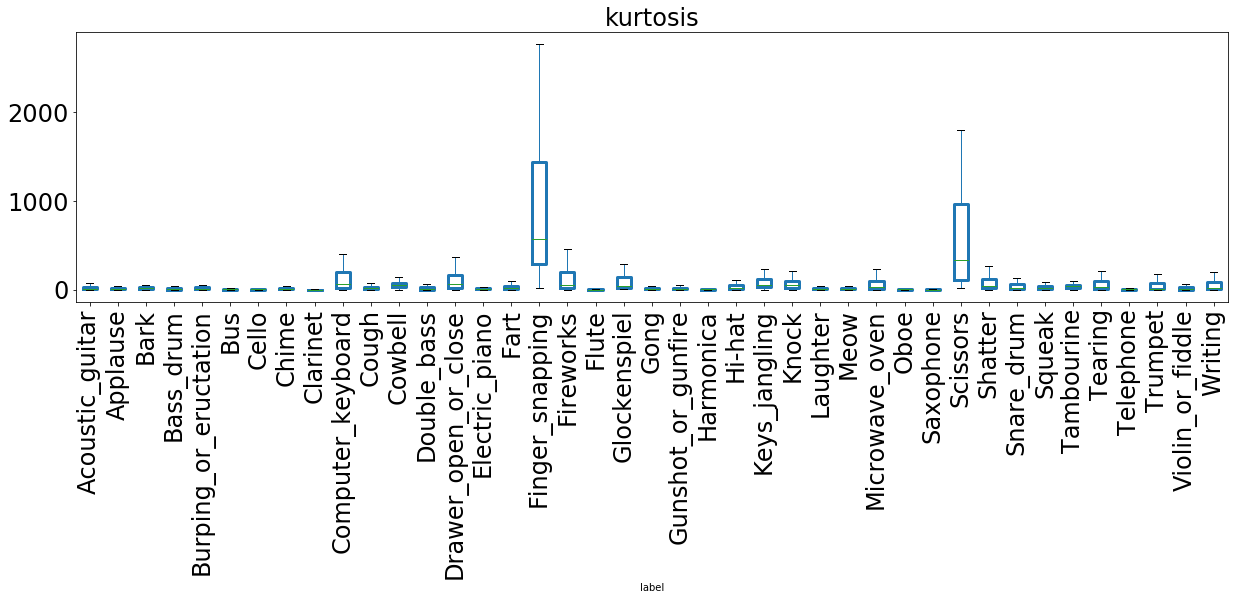

In [7]:
feature = 'kurtosis'
plot_box(feature)

# feature = 'mfcc_8_min'
# plot_box_2(feature)

# feature = 'skewness'
# plot_box(feature)


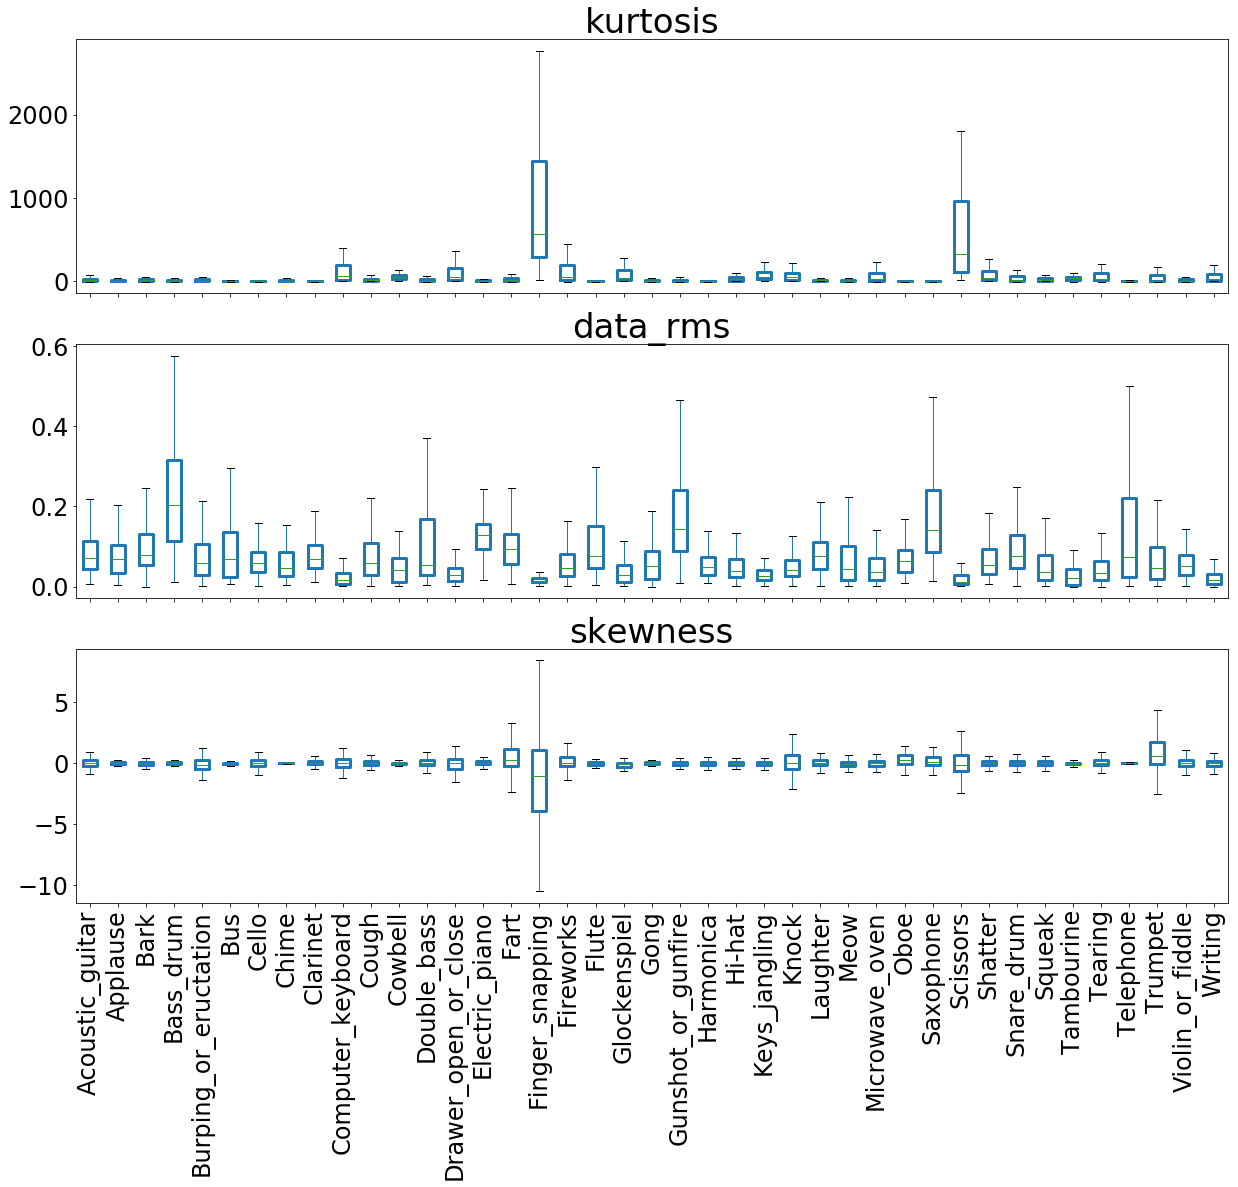

In [22]:
feature_name_1 = 'kurtosis'
feature_name_2 = 'data_rms'
feature_name_3 = 'skewness'

plot_box_3(feature_name_1, feature_name_2, feature_name_3)

### Removal of NaNs, etc

In [74]:
test_df[pd.isnull(test_df).any(axis=1)].head()

In [75]:
test_df.fillna(0, inplace=True)

### Split data into training, validation, and testing sets

### MFCC

- Similar to log-magnitude spectrograms
- Use non-linaer Mel scale frequencies, $M(f) = 1125*ln(1+f/700)$
- Use discrete cosine transformation, retaining only the lower coefficients

In [93]:
def spectral_features(fname=None, root=None, n_mfcc=20, return_fnames=False):
    feature_names = []
    for i in ['mean', 'std', 'min', 'max', 'skew', 'kurt']:
        for j in range(n_mfcc):
            feature_names.append('mfcc_{}_{}'.format(j, i))
        feature_names.append('centroid_{}'.format(i))
        feature_names.append('bandwidth_{}'.format(i))
        feature_names.append('contrast_{}'.format(i))
        feature_names.append('rolloff_{}'.format(i))
        feature_names.append('flatness_{}'.format(i))
        feature_names.append('zcr_{}'.format(i))
    
    if return_fnames:
        return feature_names

    spectral_features = [
        librosa.feature.spectral_centroid,
        librosa.feature.spectral_bandwidth,
        librosa.feature.spectral_contrast,
        librosa.feature.spectral_rolloff,
        librosa.feature.spectral_flatness,
        librosa.feature.zero_crossing_rate]
     
    try:
        data, fs = librosa.core.load(root + fname, sr=None)
        M = librosa.feature.mfcc(data, sr=fs, n_mfcc=n_mfcc)
        data_row = np.hstack((np.mean(M, axis=1), np.std(M, axis=1), np.min(M, axis=1),
                              np.max(M, axis=1), skew(M, axis=1), kurtosis(M, axis=1)))
        
        for feat in spectral_features:
            S = feat(data)[0]
            data_row = np.hstack((data_row, np.mean(S), np.std(S), np.min(S),
                                  np.max(S), skew(S), kurtosis(S)))

        return pd.Series(data_row)
        
    except (ValueError, RuntimeError):
        print("Bad file at {}".format(fname))
        return pd.Series([0]*len(feature_names))  

### Apply spectral features to DataFrame

In [94]:
if os.path.isfile('../cache/train_spectral.csv') and cache:
    train_df = pd.read_csv('../cache/train_spectral.csv')
    test_df = pd.read_csv('../cache/test_spectral.csv')
    assert len(train_df.index) == n_training
    assert len(test_df.index) == n_test
    print("Files loaded from cache")

else:
    feature_names = spectral_features(return_fnames=True)
    train_df[feature_names] = train_df['fname'].progress_apply(spectral_features, root=train_root_trimmed)
    test_df[feature_names] = test_df['fname'].progress_apply(spectral_features, root=test_root_trimmed)
    if cache:
        train_df.to_csv('../cache/train_spectral.csv', index=False)
        test_df.to_csv('../cache/test_spectral.csv', index=False)

### Train with spectral features

In [95]:
# Create dataset
X_train, X_valid, y_train, y_valid, X_test, feature_names, labels = data_split(train_df, test_df, verbose=False)
d_train, d_valid, params = lgb_dset(X_train, X_valid, y_train, y_valid, feature_names)

# Train and predict
clf = lgb.train(params, d_train, num_boost_round=2000, valid_sets=d_valid, verbose_eval=200, early_stopping_rounds=100)
p = clf.predict(X_valid, num_iteration=clf.best_iteration)

# Score
predictions = [list(np.argsort(p[i])[::-1][:3]) for i in range(len(p))]
actual = [[i] for i in y_valid]
valid_score = mapk(actual, predictions, k=3)
print("\nScore = {:.4f}".format(valid_score))

### Feature importance with spectral features

In [96]:
# Plot importances
ax = lgb.plot_importance(clf, max_num_features=10, grid=False, height=0.8, figsize=(16, 8))
plt.show()

### Create submission with spectral features

In [97]:
# CV = 0.7854, LB = 0.835
p = clf.predict(X_test, num_iteration=clf.best_iteration)
lab = preds_to_labels(p, labels)
create_submission(lab, 'submission-{:.4f}.csv'.format(valid_score))

### Prepare to train on full dataset

In [98]:
if run_full_notebook:
    params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'max_depth': 5,
        'num_leaves': 31,
        'learning_rate': 0.025,
        'feature_fraction': 0.85,
        'bagging_fraction': 0.85,
        'bagging_freq': 5,
        'num_threads': os.cpu_count(),
        'lambda_l2': 1.0,
        'min_gain_to_split': 0,
        'num_class': n_categories,
    }

    # Create dataset
    X_train, X_valid, y_train, y_valid, X_test, feature_names, labels = \
        data_split(train_df, test_df, test_size=0)
    d_train = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)

### Train, predict, create submission

In [99]:
if run_full_notebook:
    # Train and predict
    print("Begin training...")
    clf = lgb.train(params, d_train, num_boost_round=1135)

    print("Begin test predictions...")
    p = clf.predict(X_test)
    lab = preds_to_labels(p, labels)

    create_submission(lab, 'submission-test.csv')
    print("Submission created.")

    # 0.836 LB

## Next steps beginner
- Run this notebook yourself and submit the predictions
- Kaggle user Zafar has a great notebook, based on neural networks
    - https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data
    - Run his notebook and combine the predictions
    - How do different methods of combing results effect your score? (mean, geometric mean, voting, ??)
        - This could net you a top-5 place right now
- Identify and modify any hyperparameters in this notebook

## Next steps intermediate
- Try different algorithms
- Normalization of MFCC coefficients
- New/more/less features
- Add more data
    - Either external datasets or by adding noise
- Add test data with high confidence predictions to training data

## Next steps advanced
- Apply a sliding window to augment data
    - Can assume label is characterized by entire signal and average outputs
    - Can also assume label is characterized best by single frame and use highest output
- Build a neural network on MFCC's or spectrograms and either
    - A) Append calculated features to dense layer of neural network
    - B) Use low dimension bottleneck of neural network as features in other models
- Ignore me and do something better